In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.kfold_pipeline.kfold_util as kutil

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
from recordtype import recordtype
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


In [2]:
scipy.__version__

'1.5.1'

## runtime params

### change:

In [69]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n,env_run_n, poly_run_n, binning')
params = Parameters(qr_run_n=406,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=0,
                    poly_run_n=0,
                    binning='dijet'
                    )

ae_run_n = 113
#qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
#qr_run_n, qr_model_str = 7, 'dense'
#qr_run_n, qr_model_str = 7, 'dense_polyfit'
#qr_run_n, qr_model_str = 8, 'dense_70pct_train'
#qr_run_n, qr_model_str, train_share = 31, 'dense_kfold', 0
#qr_run_n, qr_model_str, train_share = 34, 'dense_kfold_lmfit11', 0 # => current best
#qr_run_n, qr_model_str, train_share = 189, 'dense_kfold_binned_ratio', 0
#qr_run_n, qr_model_str, train_share = 191, 'dense_kfold_global_ratio', 0
qr_model_str, train_share = '_'.join(['kfold',str(params.qr_run_n),str(params.env_run_n),str(params.poly_run_n)]), 0

xsec = 0
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.5, 0.9]
#quantiles = [0.1, 0.5, 0.99]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0
poly_cut = True

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

xsecs_sig   = [0,20,40,60,80,100] # signal cross sections

file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(params.qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]

In [70]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [71]:
# if poly_cut:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
# else:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
# paths.extend_in_path_data(path_ext_dict)
# paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

### fixed

In [72]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [73]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [74]:
effs

array([0.6667, 0.6667, 0.6667, 0.3333])

In [75]:
n_bins = 40
min_mjj = kutil.get_bins_from_envelope(params)[0]
max_mjj = 5600.
expo_binning = False
dijet_binning = True


if dijet_binning:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529, 1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
    bin_edges = bin_edges[bin_edges>=min_mjj]
elif expo_binning:
    x_shift = 3
    lin_bins = np.linspace(0.,1.,n_bins)
    exp_bins = lin_bins/(np.exp(-lin_bins+x_shift)/np.exp(x_shift-1))
    bin_edges = exp_bins*(max_mjj-min_mjj)+min_mjj
    
else: # simple linear binning
    bin_edges = np.array(np.linspace(min_mjj, max_mjj, n_bins).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
    
bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[(bin_edges>=min_mjj) & (bin_edges<=max_mjj)]
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [76]:
bin_edges

array([1287.5, 1353.5, 1422. , 1493. , 1566.5, 1642.5, 1721. , 1802.5,
       1887. , 1974.5, 2065. , 2158.5, 2255.5, 2355.5, 2459. , 2566. ,
       2676.5, 2791. , 2909. , 3031. , 3157. , 3287. , 3421.5, 3561. ,
       3705. , 3853. , 4006. , 4164.5, 4328. , 4497. , 4671.5, 4851.5,
       5037.5, 5229.5, 5450.5])

In [77]:
min_mjj

1287.5

## read histogram data

In [78]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [79]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

#     for sample_id in sample_ids:
#         samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    for sample_id in sample_ids:
        in_path = os.path.join(paths,sample_id+'.h5') #paths.in_file_path(sample_id)
        samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
        print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)
    
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [80]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_406/env_run_0/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_406/env_run_0/poly_run_0/GtoWW35naReco.h5


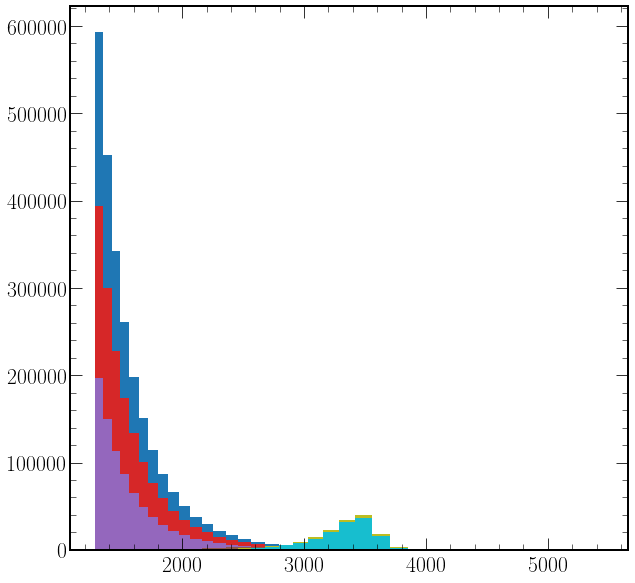

In [81]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, 113, params.qr_run_n, sample_id_sig, xsec_train, bin_edges, input_path)

In [82]:
quants

[0.0, 0.3, 0.5, 0.7, 0.9]

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


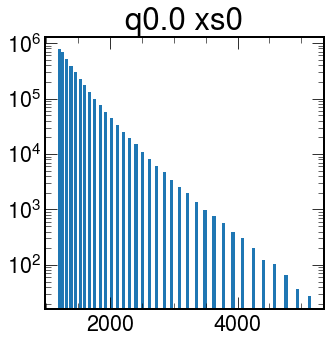

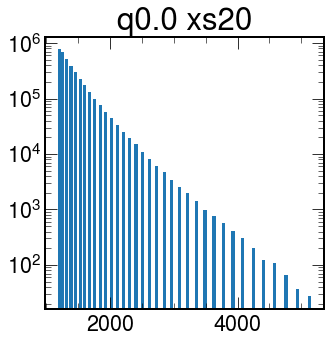

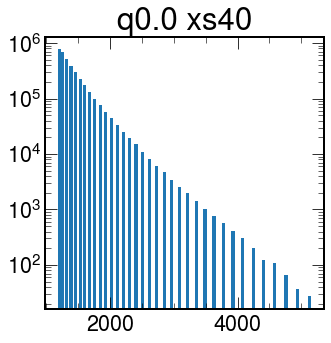

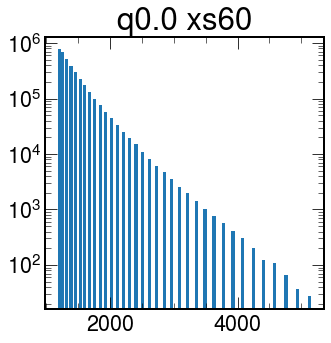

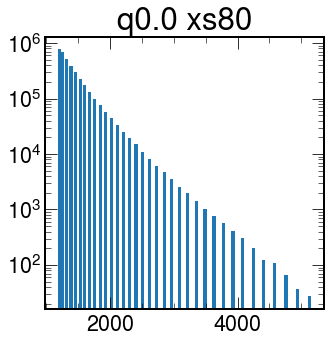

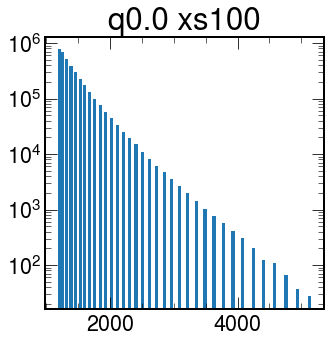

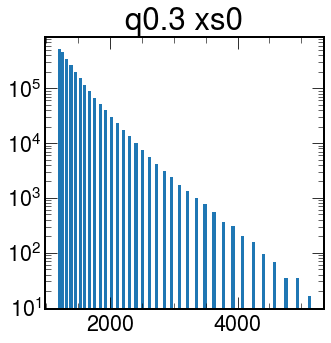

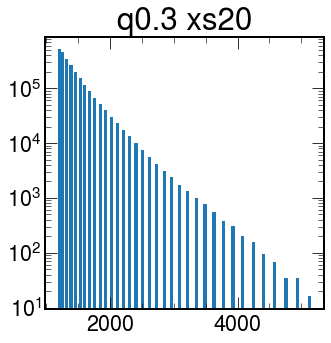

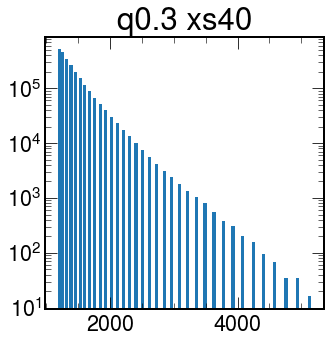

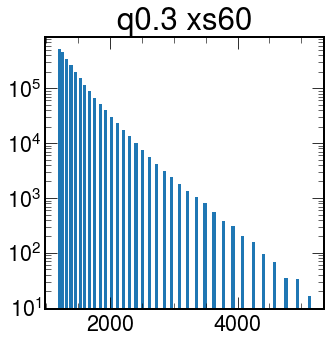

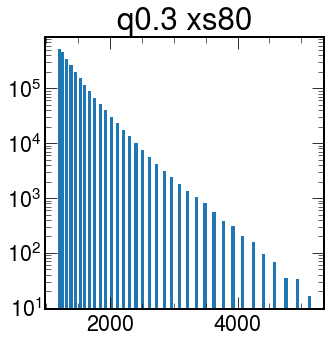

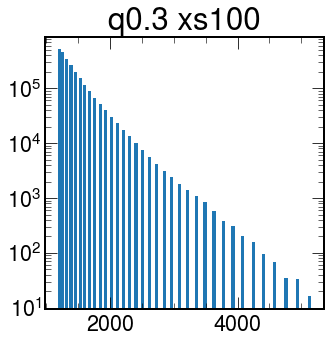

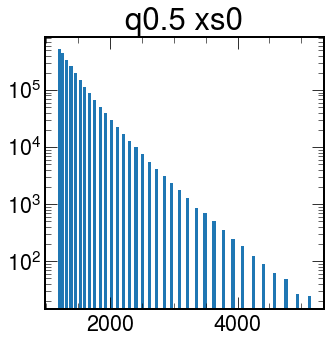

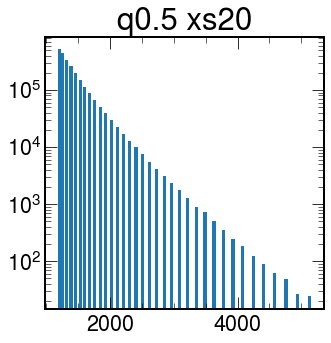

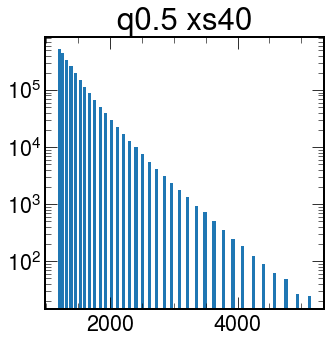

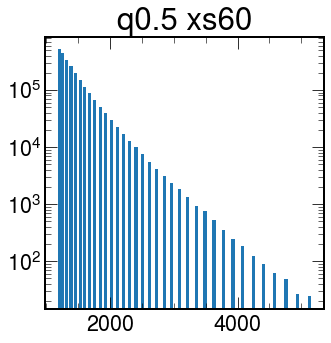

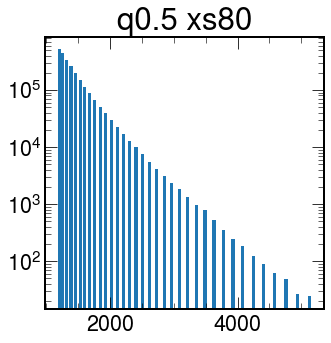

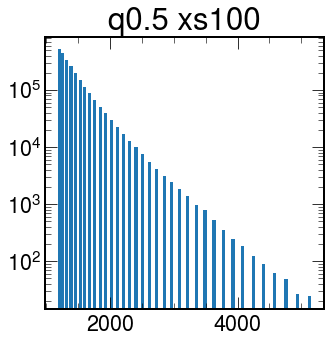

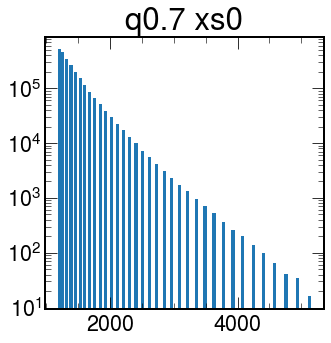

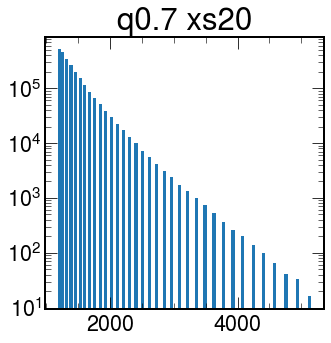

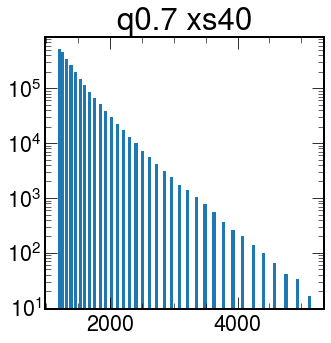

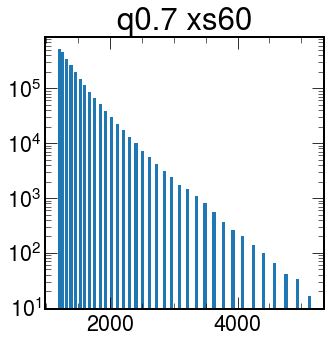

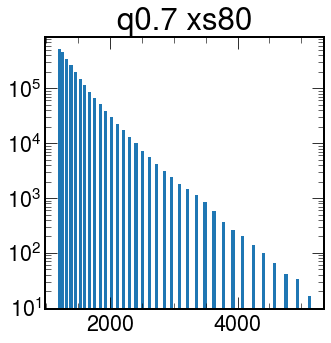

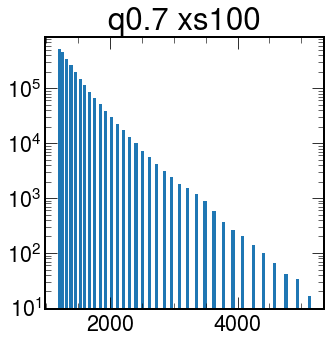

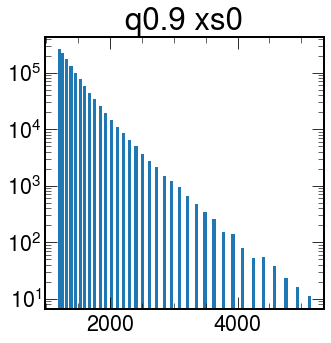

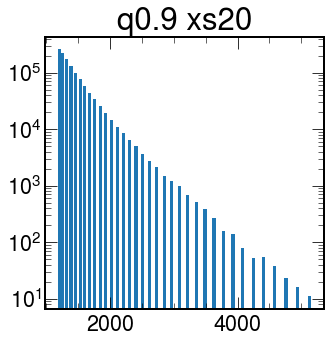

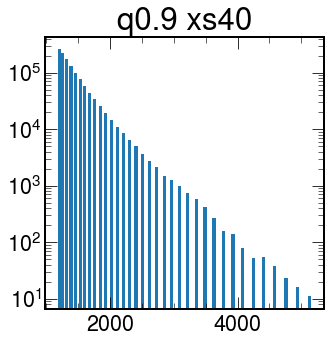

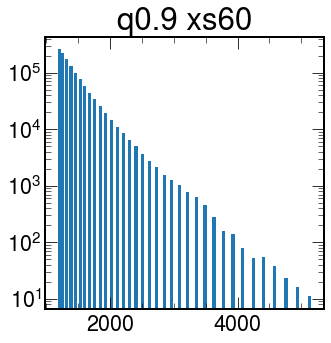

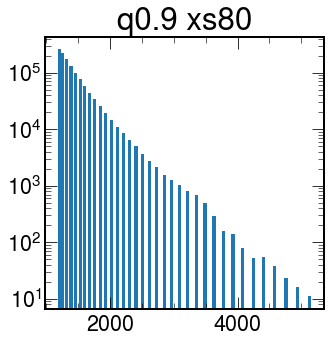

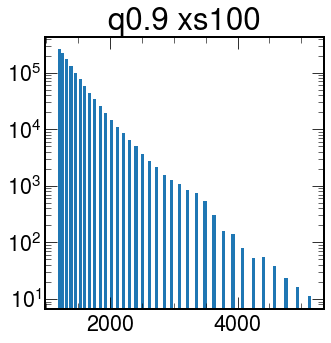

In [66]:
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure(figsize=(5, 5))
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

In [83]:
# print N samples
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        print('quant {:>4}, xsec {:>3}: {:>8} events'.format(quant, xsec, int(sum(yy))))

quant  0.0, xsec   0:  2470723 events
quant  0.0, xsec  20:  2470810 events
quant  0.0, xsec  40:  2470898 events
quant  0.0, xsec  60:  2470986 events
quant  0.0, xsec  80:  2471074 events
quant  0.0, xsec 100:  2471162 events
quant  0.3, xsec   0:  1633372 events
quant  0.3, xsec  20:  1633456 events
quant  0.3, xsec  40:  1633541 events
quant  0.3, xsec  60:  1633625 events
quant  0.3, xsec  80:  1633710 events
quant  0.3, xsec 100:  1633794 events
quant  0.5, xsec   0:  1630754 events
quant  0.5, xsec  20:  1630876 events
quant  0.5, xsec  40:  1630998 events
quant  0.5, xsec  60:  1631120 events
quant  0.5, xsec  80:  1631242 events
quant  0.5, xsec 100:  1631364 events
quant  0.7, xsec   0:  1650407 events
quant  0.7, xsec  20:  1650620 events
quant  0.7, xsec  40:  1650834 events
quant  0.7, xsec  60:  1651048 events
quant  0.7, xsec  80:  1651261 events
quant  0.7, xsec 100:  1651475 events
quant  0.9, xsec   0:   818481 events
quant  0.9, xsec  20:   818671 events
quant  0.9, 

# Chi Square tests

In [84]:
def chi_square_pearson(observed, expected):
    statistics_per_bin = [(o-e)**2/e for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [85]:
def chi_square_neyman(observed, expected):
    statistics_per_bin = [(o-e)**2/max(o,1) for o, e in zip(observed, expected)] # adapted to zero bin counts
    return sum(statistics_per_bin), statistics_per_bin

In [86]:
def chi_square_poisson_likeli(observed, expected):
    statistics_per_bin = [2*(e - o + (o * np.log(o/e) if o else 0)) for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [87]:
np.set_printoptions(precision=4, suppress=False)

In [88]:
df = n_bins - 1 # degrees of freedom = number of measurements (=bins) - 1

chi_sq_pearson_stats = {}
chi_sq_neyman_stats = {}
chi_sq_poisson_like = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_p = []
    pvals_p = []
    test_stat_xsecs_n = []
    pvals_n = []
    test_stat_xsecs_l = []
    pvals_l = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        t_p, _ = chi_square_pearson(observed, expected)
        pval_p = 1 - chi2.cdf(t_p, df=df)
        t_n, _ = chi_square_neyman(observed, expected)
        pval_n = 1 - chi2.cdf(t_n, df=df)
        t_l, _ = chi_square_poisson_likeli(observed, expected)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        test_stat_xsecs_p.append(t_p)
        test_stat_xsecs_n.append(t_n)
        test_stat_xsecs_l.append(t_l)
        pvals_p.append(pval_p)
        pvals_n.append(pval_n)
        pvals_l.append(pval_l)
    
    print('pearson for quantile', quant_test)
    print('ch2:' , np.array(test_stat_xsecs_p))
    print('p-val: ', np.array(pvals_p))
    print('neyman for quantile', quant_test)
    print(np.array(test_stat_xsecs_n))
    print('p-val: ', np.array(pvals_n))
    print('likelihood for quantile', quant_test)
    print(np.array(test_stat_xsecs_l))
    print('p-val: ', np.array(pvals_l))
    print('\n')
    
    chi_sq_pearson_stats[quant_test] = test_stat_xsecs_p
    chi_sq_neyman_stats[quant_test] = test_stat_xsecs_n
    chi_sq_poisson_like[quant_test] = test_stat_xsecs_l

pearson for quantile 0.3
ch2: [470.5054 475.6356 481.1628 487.08   493.3805 500.0576]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.3
[472.7403 477.0435 481.6424 486.526  491.6843 497.1073]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.3
[470.6318 475.4641 480.6552 486.1965 492.0795 498.2963]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.5
ch2: [379.0126 390.1351 403.2621 418.3578 435.3873 454.3165]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.5
[392.1972 401.9273 413.1816 425.8595 439.8699 455.1302]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.5
[382.2678 392.9015 405.3638 419.5921 435.5269 453.1122]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.7
ch2: [173.45   192.9596 223.4231 264.6421 316.4231 378.5775]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.7
[184.5484 202.004  227.891  261.1247 300.8159 346.2265]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.7
[175.76   194.5501 223.3703 261.65   308.8744 364.5772]
p-val:  [0. 0. 0. 0. 0

### draw test statistics on chi-square distribution graph

saving fig to  fig/qr_run_406/env_run_0/poly_run_0/chi_square_Pearson.png
saving fig to  fig/qr_run_406/env_run_0/poly_run_0/chi_square_Neyman.png
saving fig to  fig/qr_run_406/env_run_0/poly_run_0/chi_square_PoissonLike.png


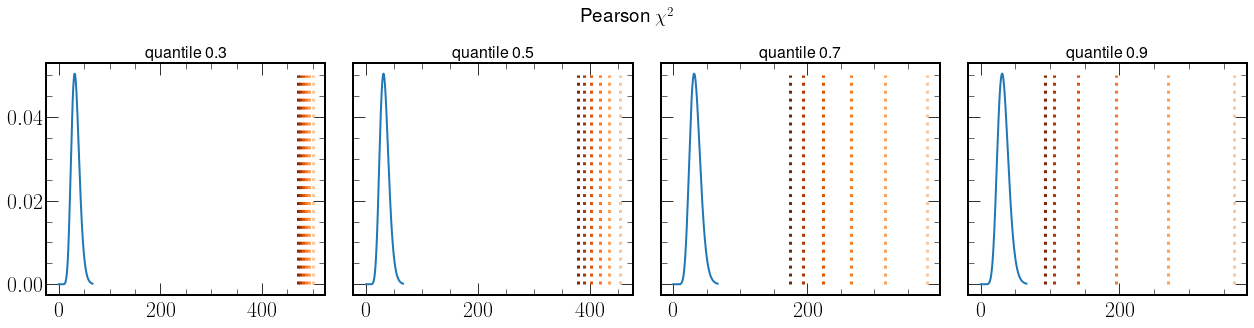

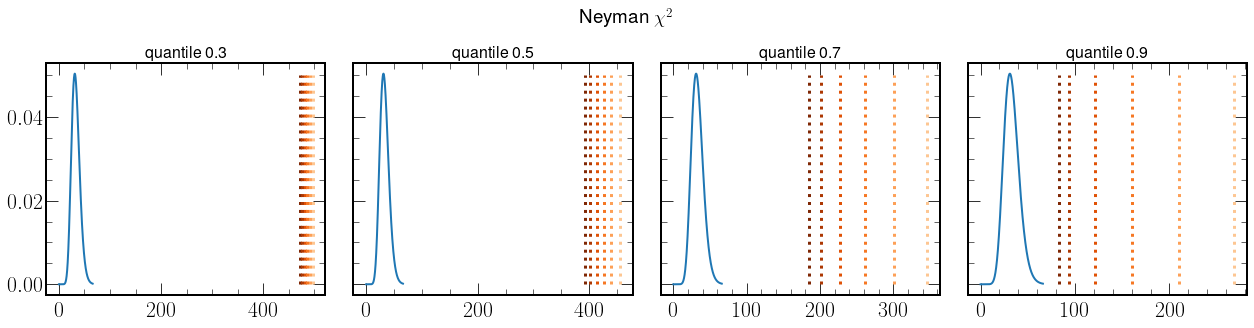

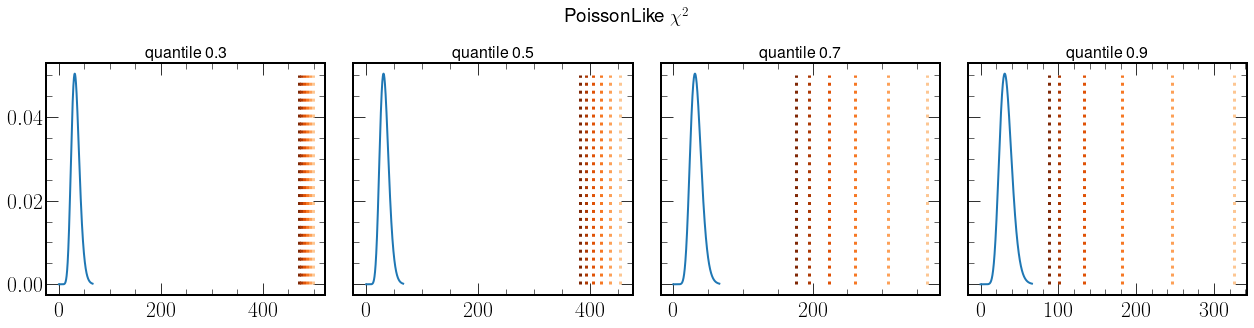

In [89]:
chi_sq_results = {
    'Pearson': chi_sq_pearson_stats,
    'Neyman' : chi_sq_neyman_stats,
    'PoissonLike': chi_sq_poisson_like
}

x = np.arange(0, df*2, 0.001)
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.0, 1.0, len(xsecs_sig)+2))[::-1]

for method, val_dict in chi_sq_results.items():
    fig, axs = plt.subplots(1,len(quants)-1,sharey=True,figsize=(18,5))
    for quant, ax in zip(quants[template_q_idx+1:],axs.flat):
        chi_sq_vals = val_dict[quant]
        ax.plot(x, chi2.pdf(x, df=df), lw=2) # df = num-observed - 1
        ax.vlines(chi_sq_vals,colors=cmap,ymin=0,ymax=0.05, ls=':',lw=3)
        ax.set_title('quantile {}'.format(quant), fontsize=16)
    fig.suptitle(r'{} $\chi^2$'.format(method), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(fig_dir,'chi_square_{}.png'.format(method))
    print('saving fig to ', fig_path)
    plt.savefig(fig_path)

In [90]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    test_stat_xsecs_p = []
    test_stat_xsecs_n = []
    for xsec in [xsecs_sig[0]]:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        print('\nquant ' +str(quant_test)+', xsec '+ str(xsec))
        print('obs')
        print(np.array(observed))
        print('total events ' + str(sum(observed)))
        print('exp')
        print(np.array(expected))


quant 0.3, xsec 0
obs
[3.8950e+05 2.9596e+05 2.2474e+05 1.7191e+05 1.3108e+05 9.9976e+04
 7.6384e+04 5.8139e+04 4.4721e+04 3.4204e+04 2.5953e+04 1.9793e+04
 1.5216e+04 1.1485e+04 8.7670e+03 6.5530e+03 4.9230e+03 3.6020e+03
 2.7950e+03 2.0790e+03 1.5190e+03 1.0870e+03 8.9300e+02 6.3600e+02
 4.5500e+02 2.9500e+02 2.3400e+02 1.6200e+02 1.2400e+02 6.5000e+01
 5.1000e+01 2.7000e+01 1.8000e+01 1.2000e+01]
total events 1633372.0
exp
[3.9529e+05 3.0138e+05 2.2834e+05 1.7426e+05 1.3167e+05 1.0046e+05
 7.6455e+04 5.8061e+04 4.4248e+04 3.3616e+04 2.5311e+04 1.9509e+04
 1.4493e+04 1.1169e+04 8.4120e+03 6.3460e+03 4.6260e+03 3.5260e+03
 2.6767e+03 1.9340e+03 1.5000e+03 1.0307e+03 7.7000e+02 5.9200e+02
 3.9800e+02 3.2133e+02 2.3667e+02 1.7667e+02 1.1267e+02 8.5333e+01
 6.1333e+01 3.9333e+01 2.9333e+01 1.8000e+01]

quant 0.5, xsec 0
obs
[3.9168e+05 2.9698e+05 2.2522e+05 1.7069e+05 1.2994e+05 9.8804e+04
 7.6224e+04 5.7952e+04 4.4235e+04 3.3684e+04 2.5896e+04 1.9445e+04
 1.4856e+04 1.1332e+04 8.5760e+

In [91]:
dat_tmplt = hist_data[quant_tmplt]

In [92]:
for quant, eff in zip(quants[template_q_idx+1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(np.asarray(p_vals))

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[8.0193e-79 7.2911e-80 5.4955e-81 3.4437e-82 1.7990e-83 7.8565e-85]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[2.1052e-60 1.2639e-62 2.9701e-65 2.7598e-68 1.0238e-71 1.5307e-75]
pvals for quantile 0.7
[0, 20, 40, 60, 80, 100]
[5.5733e-21 1.6520e-24 3.7914e-30 5.7201e-38 5.0942e-48 2.5709e-60]
pvals for quantile 0.9
[0, 20, 40, 60, 80, 100]
[1.3720e-07 1.3439e-09 3.3884e-15 6.3050e-25 4.5014e-39 1.0775e-57]


In [93]:
quant_test = 0.5
xsec = 0
eff = effs[quants.index(quant_test)-1]#0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [94]:
n_bins

34

In [95]:
eff

0.6666666666666665

In [96]:
# observed
obs = hist_data[quant_test][xsec]

In [97]:
# expected
expt = hist_data[quant_tmplt][xsec]*eff

In [98]:
statistic = 0
for e, o in zip(hist_data[quant_tmplt][xsec]*eff, hist_data[quant_test][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 391679.0, exp 395287.9999999999, stat 32.95035771386726
obs 296978.0, exp 301380.6666666666, stat 64.31558464636342
obs 225215.0, exp 228338.66666666663, stat 42.7316739073724
obs 170691.0, exp 174255.99999999997, stat 72.93421747314179
obs 129945.0, exp 131671.99999999997, stat 22.65120147031943
obs 98804.0, exp 100459.33333333331, stat 27.275996699603628
obs 76224.0, exp 76455.33333333331, stat 0.6999526230274166
obs 57952.0, exp 58060.66666666666, stat 0.20338113773711985
obs 44235.0, exp 44247.99999999999, stat 0.003819381666963724
obs 33684.0, exp 33615.99999999999, stat 0.13755354593053876
obs 25896.0, exp 25311.33333333333, stat 13.505219444956811
obs 19445.0, exp 19509.33333333333, stat 0.212143475487484
obs 14856.0, exp 14492.666666666664, stat 9.108821319594707
obs 11332.0, exp 11168.666666666664, stat 2.3886269125928408
obs 8576.0, exp 8411.999999999998, stat 3.1973371374228012
obs 6583.0, exp 6345.999999999998, stat 8.851087299086178
obs 4667.0, exp 4625.999999999999, s

In [99]:
statistic

379.01260020879033

In [100]:
scipy.stats.chisquare(f_obs=hist_data[quant_test][xsec], f_exp=hist_data[quant_tmplt][xsec]*eff, axis=0)

Power_divergenceResult(statistic=379.01260020879045, pvalue=2.1052230010201422e-60)

In [34]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('Pearson Chi^2 p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

Text(0.5, 1.0, 'kfold_407_0_0 model, 0.0-0.3 template quantile')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f532ace8200> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'kfold_407_0_0 model, 0.0-0.3 template quantile'

Here is the full report generated by latex:
latex: /cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/libtiff.so.5: no version information available (required by /lib64/libpoppler.so.46)
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/afs/cern.ch/user/k/kiwoznia/.cache/matplotlib/tex.cache/2ea554bffd705d9fcccbe
a5df35d8bd9.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 2ea554bffd705d9fcccbea5df35d8bd9.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{18.000000}{22.500000}{\sffamily kfold_
                                                  407_0_0 model, 0.0-0.3 tem...
No pages of output.
Transcript written on 2ea554bffd705d9fcccbea5df35d8bd9.log.




RuntimeError: latex was not able to process the following string:
b'kfold_407_0_0 model, 0.0-0.3 template quantile'

Here is the full report generated by latex:
latex: /cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/libtiff.so.5: no version information available (required by /lib64/libpoppler.so.46)
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/afs/cern.ch/user/k/kiwoznia/.cache/matplotlib/tex.cache/2ea554bffd705d9fcccbe
a5df35d8bd9.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./2ea554bffd705d9fcccbea5df35d8bd9.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{18.000000}{22.500000}{\sffamily kfold_
                                                  407_0_0 model, 0.0-0.3 tem...
No pages of output.
Transcript written on 2ea554bffd705d9fcccbea5df35d8bd9.log.




<Figure size 504x504 with 1 Axes>

### poisson likelihood pval

In [77]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    
    p_vals = []
    
    for xsec in xsecs_sig:
    
        t_l, _ = chi_square_poisson_likeli(dat[xsec], dat_tmplt[xsec]*eff)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        p_vals.append(pval_l)
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('poisson likelihood p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Text(0.5, 1.0, 'kfold_406_0_0 model, 0.0-0.3 template quantile')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fce00721200> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'kfold_406_0_0 model, 0.0-0.3 template quantile'

Here is the full report generated by latex:
latex: /cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/libtiff.so.5: no version information available (required by /lib64/libpoppler.so.46)
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/afs/cern.ch/user/k/kiwoznia/.cache/matplotlib/tex.cache/614f7fdbe2fa835c9139a
0d1ff2ff2fd.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./614f7fdbe2fa835c9139a0d1ff2ff2fd.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{18.000000}{22.500000}{\sffamily kfold_
                                                  406_0_0 model, 0.0-0.3 tem...
No pages of output.
Transcript written on 614f7fdbe2fa835c9139a0d1ff2ff2fd.log.




RuntimeError: latex was not able to process the following string:
b'kfold_406_0_0 model, 0.0-0.3 template quantile'

Here is the full report generated by latex:
latex: /cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/libtiff.so.5: no version information available (required by /lib64/libpoppler.so.46)
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/afs/cern.ch/user/k/kiwoznia/.cache/matplotlib/tex.cache/614f7fdbe2fa835c9139a
0d1ff2ff2fd.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./614f7fdbe2fa835c9139a0d1ff2ff2fd.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{18.000000}{22.500000}{\sffamily kfold_
                                                  406_0_0 model, 0.0-0.3 tem...
No pages of output.
Transcript written on 614f7fdbe2fa835c9139a0d1ff2ff2fd.log.




<Figure size 504x504 with 1 Axes>

## Kolmogorov-Smirnov 2-sample test

In [47]:
# empirical CDF
def ecdf(pdf):
    cdf = np.cumsum(pdf)
    return cdf / cdf[-1]

In [48]:
def kolmogorov_smirnov(observed, expected):
    obs_cdf = ecdf(observed)
    exp_cdf = ecdf(expected)
    return max(abs(obs_cdf-exp_cdf))

In [49]:
def pval_ks(ks_t, n, m):
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    en = m * n / (m + n)
    return kstwo.sf(ks_t, np.round(en))

In [50]:
ks_stats = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ks = []
    pvals_ks = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        n, m = float(np.sum(observed)), float(np.sum(expected))
        t_ks = kolmogorov_smirnov(observed, expected)
        p_ks = pval_ks(t_ks, n, m)
        
        test_stat_xsecs_ks.append(t_ks)
        pvals_ks.append(p_ks)
    
    print('KS for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ks))
    print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    ks_stats[quant_test] = test_stat_xsecs_ks

KS for quantile 0.3
t: [0.0031 0.0031 0.0031 0.0031 0.0031 0.0031]
p-val:  [1.5120e-10 1.4601e-10 1.4099e-10 1.3614e-10 1.2927e-10 1.2094e-10]


KS for quantile 0.5
t: [0.0009 0.0009 0.0009 0.0009 0.0009 0.0009]
p-val:  [0.2682 0.2621 0.2562 0.2503 0.2446 0.239 ]


KS for quantile 0.7
t: [0.0011 0.0011 0.0011 0.0011 0.0012 0.0012]
p-val:  [0.1085 0.1011 0.0941 0.0875 0.0812 0.0754]


KS for quantile 0.9
t: [0.0025 0.0026 0.0026 0.0027 0.0027 0.0028]
p-val:  [0.0011 0.0008 0.0006 0.0004 0.0003 0.0002]




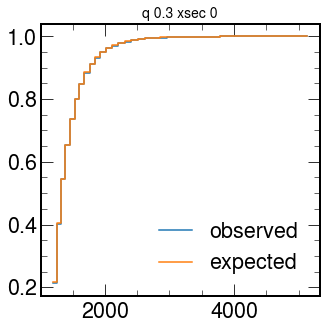

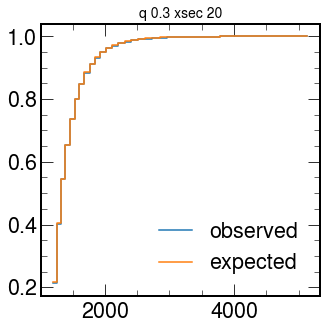

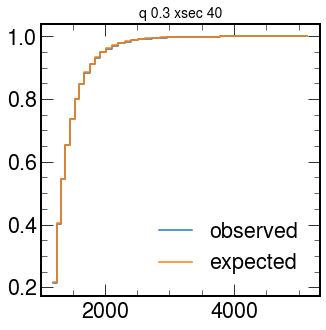

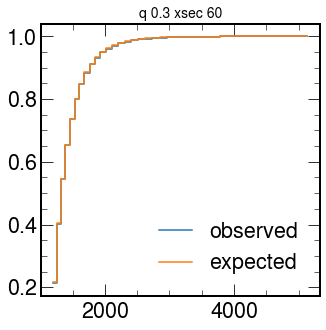

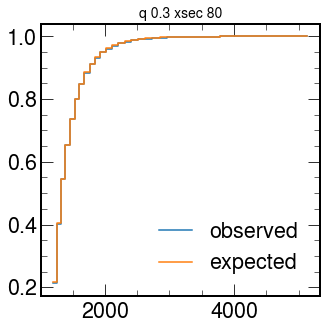

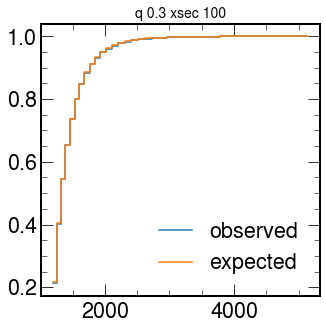

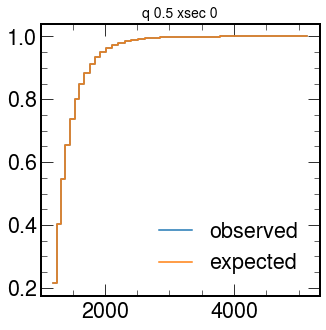

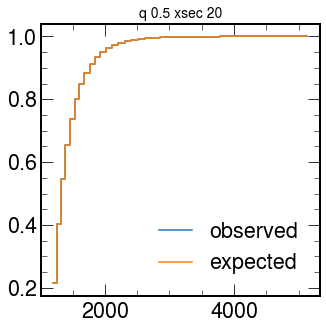

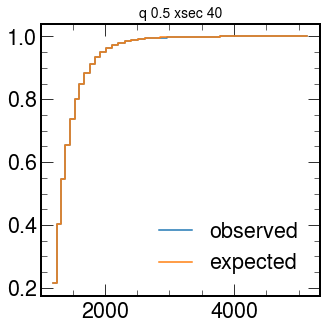

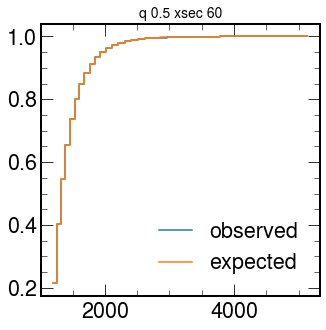

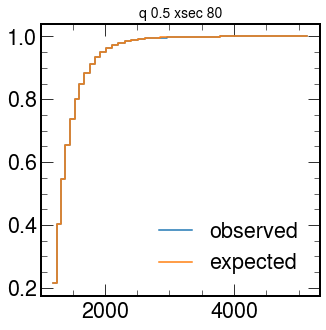

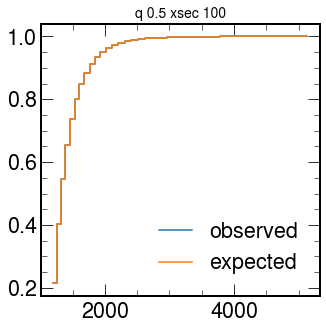

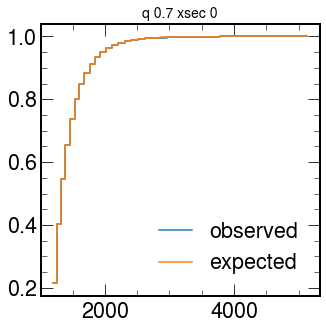

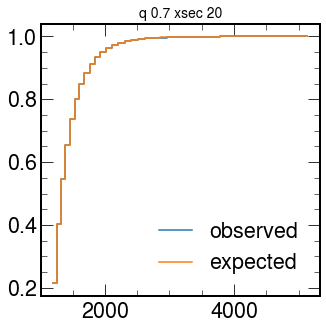

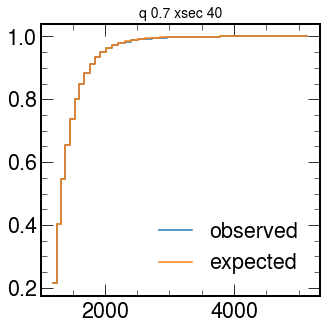

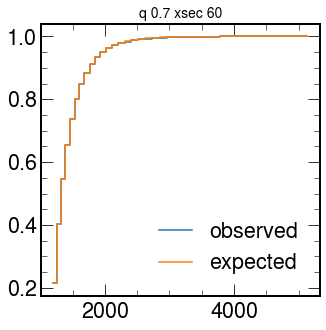

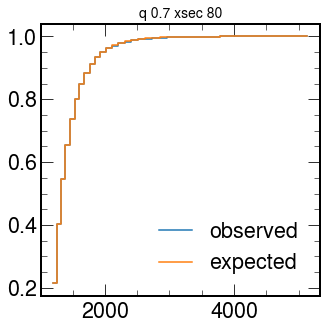

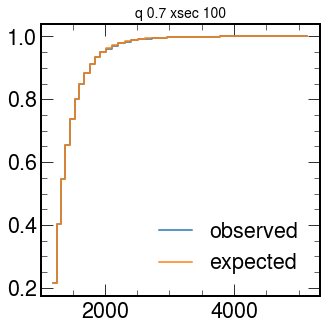

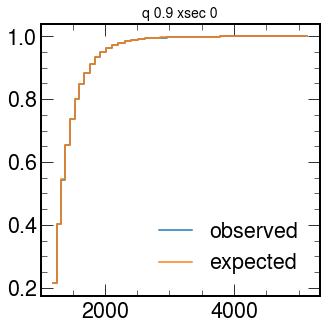

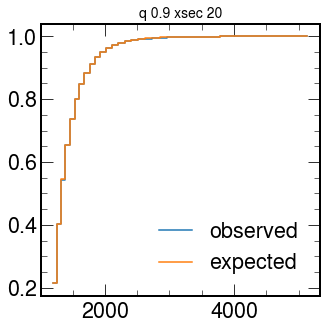

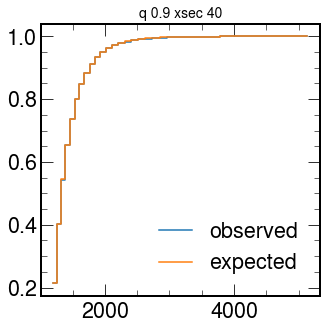

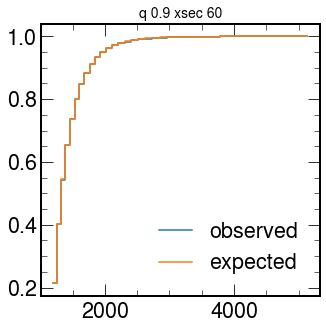

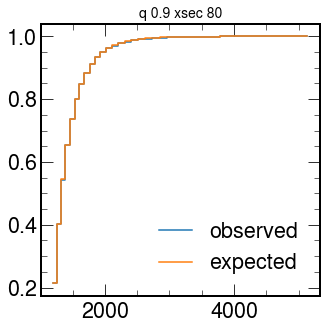

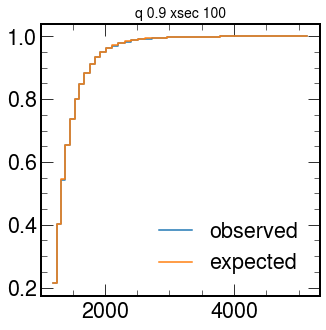

In [51]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


## KS from pdfs

In [52]:
mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)

NameError: name 'qr_run_n' is not defined

In [ ]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


In [ ]:
len(mjj_vals_sig)

In [ ]:
def get_ks_test_stat_pval(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
def get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2):
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
s1 = np.random.normal(size=100000)
s2 = np.random.normal(size=100000)

In [ ]:
from scipy import stats
stats.ks_2samp(s1, s2)

In [ ]:
counts1, _, _ = plt.hist(s1, bins=100)
counts2, _, _ = plt.hist(s2, bins=100)
n1, n2 = float(len(s1)), float(len(s2))
cdf1 = np.cumsum(counts1)
cdf1 = cdf1 / cdf1[-1]
cdf2 = np.cumsum(counts2)
cdf2 = cdf2 / cdf2[-1]
t_ks, p_ks = get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2)

In [ ]:
print(t_ks, p_ks)

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(counts1, label='counts_1', drawstyle='steps-post')
plt.plot(counts2, label='counts_2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(cdf1, label='cdf1', drawstyle='steps-post')
plt.plot(cdf2, label='cdf2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [53]:
s1 = np.random.normal(loc=1, size=10000)
s2 = np.random.normal(loc=2, size=100)

In [54]:
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.379, pvalue=2.7766677845875165e-13)

In [55]:
s1 = np.random.normal(scale=1, size=10000)
s2 = np.random.normal(scale=2, size=100)
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.207, pvalue=0.0003385066199647069)